# Package and source data imports
first let's import all the toys we'll use

In [141]:
# -*- coding: utf-8 -*-
#%%
import pandas as pd
import datetime as dt
import numpy as np
import holidays
import datetime as dt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn import svm
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV
from sklearn.inspection import permutation_importance


next we bring in the weather data by looping through each of the 4 csv files, one for each year. i had prior knowledge of what the headings of these files looked like. so i knew which columns i wanted to use. to get the best design matrix possible, that's basically all of the useful weather data columns. then we coerce the data type of the date/time column as that will help us later. then we create a column that is the day name (ie "monday", "friday", "saturday") etc.... finally we get rid of the degree symbol because we all know what it means and nobody has time to type, let alone remember the ALT+ code for it.

In [142]:
#%%  compile weather data
weatherData = pd.DataFrame()
fileList = ['en_climate_daily_ON_6105976_2016_P1D.csv',
            'en_climate_daily_ON_6105976_2017_P1D.csv',
            'en_climate_daily_ON_6105976_2018_P1D.csv',
            'en_climate_daily_ON_6105976_2019_P1D.csv']

columns_keep = ['Date/Time',
    'Max Temp (°C)',
    'Min Temp (°C)',
    'Mean Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow on Grnd (cm)']

for file in fileList:
    incCSV = pd.read_csv(file,usecols = columns_keep)
    weatherData = weatherData.append(incCSV)

weatherData['Date/Time'] = pd.to_datetime(weatherData['Date/Time'])
weatherData['weekday']=weatherData['Date/Time'].dt.day_name()
weatherData.columns = weatherData.columns.str.replace('°', '')

i suspect that commuters are going to make up a good portion of the cyclists out on the roads on any given day. which means i think the cyclist count will be somewhat influenced by whether it is a working day or a holiday. so the easiest way to do that is to make a new column to determine whether each date is a holiday or not. luckily, there is a python library for this, so we can do it in one line.

In [143]:
#%% label holidays
ontario_holidays = holidays.Canada(prov = 'ON')

weatherData['holiday?'] = weatherData['Date/Time'].apply(lambda x:'holiday' if x in ontario_holidays else 'non-holiday')

have i meantioned i'm a huge fan of professional road cycling? maybe some (albeit tiny) number of people on bikes are out there because they know the Tour De France (the most important bike race in the world, it lasts 3 weeks) is going on. the data scientist in me knows this is probably a longshot, but it could be fun for a discussion. it happens every year for 3 weeks in july. so let's add a column that will tell us whether the tour de france is going on on any given day over the past 4 years. we do this by creating a list of the start and ending date of each year's iteration of the tour and creating a range of dates between those as days that the race is on for that year. then just check each date in the set against the tour dates.

In [144]:
#%% add worldtour dates

def addWTDates(dataFrame):
    tourDates = []
    tourStartsEnds = [dt.date(2016,7,2), 
            dt.date(2016,7,24), 
            dt.date(2017,7,1),
            dt.date(2017,7,23),
            dt.date(2018,7,7),
            dt.date(2018,7,29),
            dt.date(2019,7,6),
            dt.date(2019,7,28)]
    
    for i in range(0,len(tourStartsEnds), 2):
        tourRange = pd.date_range(tourStartsEnds[i],tourStartsEnds[i+1]-dt.timedelta(days=1),freq='d')
        tourDates.extend(tourRange)
    

    dataFrame['world tour?'] = dataFrame['Date/Time'].apply(lambda x:'tour' if x in tourDates else 'no tour')
    return dataFrame

weatherData = addWTDates(weatherData)

now let's work on the data we are trying to predict. this is the number of cyclists in ottawa on any given day. now how do we know that? there are sensors located at 12 (give or take) intersections throughout the city. they sense the number of bikes that go by on any given day. so, with some caveats: 1) leaving some room for people who will not cross any of these sensors, 2) acknowledging that some people are out on routes that will cross more than one of these sensors, we can make an estimate that the sum of all the sensors' counts will give a pretty good idea of the number of cyclists out on the roads in ottawa on any given day.

each year's data is in an excel sheet. again, i have knowledge of the header of the data files, so i know what columns we want. the sensors in the sensor list were chosen because those are the only sensors that were fully operational on most dates of all 4 years for which we are doing this investigation. so let's read in the 4 sheets by looping through them and appending each sheet's data to the combo of the prior years. we can also create a column for the total (sum of all sensors data for that day). we can also coerce the date column

In [145]:
#%% bike volume data
bikeVolumeData = pd.DataFrame()

sensorList = ['1^ALEX',
                '2^ORPY',
                '3^COBY',
                '5^LMET',
                '10^OGLD',
                '11 OBVW',
                '12a^ADAWE',
                '12b^ADAWE',
                'Date']


sheetList = ['2016','2017','2018','2019']

for year in sheetList:
    incoming = pd.read_excel('bike_counter.xlsx',
                                   sheet_name = year,
                                   usecols = sensorList)
    
    bikeVolumeData = bikeVolumeData.append(incoming)

bikeVolumeData['total'] = bikeVolumeData.sum(axis=1)
bikeVolumeData['Date']=pd.to_datetime(bikeVolumeData['Date'])

In [146]:
display(bikeVolumeData.head())
display(bikeVolumeData.shape)

,Date,1^ALEX,2^ORPY,3^COBY,5^LMET,10^OGLD,11 OBVW,12a^ADAWE,12b^ADAWE,total
0,2016-01-01,0.0,0.0,9.0,31.0,1.0,1.0,44.0,701.0,787.0
1,2016-01-02,0.0,1.0,23.0,61.0,15.0,13.0,63.0,466.0,642.0
2,2016-01-03,1.0,3.0,11.0,29.0,18.0,4.0,66.0,530.0,662.0
3,2016-01-04,1.0,4.0,54.0,187.0,50.0,4.0,69.0,417.0,786.0
4,2016-01-05,2.0,8.0,64.0,245.0,55.0,4.0,68.0,507.0,953.0


(1461, 10)

# Data Cleaning

we can start with the simplest layer of data cleaning, which is to see if there are any dates where one or more sensors weren't reporting data properly. these should result in blanks or NaNs in the raw data as extracted from the excel sheets.

In [147]:
#%% data cleaning
nancounts =[]
for col in bikeVolumeData.columns:
    nancounts.append(bikeVolumeData[col].isna().sum())

nancounts

[0, 239, 146, 145, 40, 1, 2, 92, 92, 0]

yikes. that's a lot of NaNs. we have some choices of how to deal with these. one would be to actually use a machine learning algorithm, much like the one we're developing here, to try and predict them. but in the interest of simplicity, let's just say that every day with a non-reporting sensor is a day whose data we can't trust. so what happens to our data set if we remove each row that has a NaN in it.

In [148]:
#%% drop days with any sensors reporting NaN
bvdClean = bikeVolumeData.dropna()
print(bvdClean.shape)

(1089, 10)


ropping each row with a NaN present in it will take our dample count down from  to 1461 to 1089. that's a big loss. another option would be to remove one sensor entirely. ie the one one most prone to failing. which is the 1st one. if we did that, and then removed all rows with NaNs from other sensors, this may help keep a higher sample count. but at the risk of losing and entire sensor's worth of data from the total.

In [149]:
bvd = bikeVolumeData.drop(columns = ['1^ALEX'])
bvd = bvd.dropna()
display(bvd)
display(bvd.shape)

,Date,2^ORPY,3^COBY,5^LMET,10^OGLD,11 OBVW,12a^ADAWE,12b^ADAWE,total
0,2016-01-01,0.0,9.0,31.0,1.0,1.0,44.0,701.0,787.0
1,2016-01-02,1.0,23.0,61.0,15.0,13.0,63.0,466.0,642.0
2,2016-01-03,3.0,11.0,29.0,18.0,4.0,66.0,530.0,662.0
3,2016-01-04,4.0,54.0,187.0,50.0,4.0,69.0,417.0,786.0
4,2016-01-05,8.0,64.0,245.0,55.0,4.0,68.0,507.0,953.0
...,...,...,...,...,...,...,...,...,...
302,2019-10-30,1021.0,716.0,1543.0,574.0,516.0,1066.0,1405.0,6841.0
303,2019-10-31,518.0,423.0,848.0,267.0,271.0,622.0,976.0,3925.0
304,2019-11-01,460.0,421.0,911.0,236.0,254.0,591.0,997.0,3870.0
305,2019-11-02,141.0,157.0,284.0,95.0,114.0,322.0,886.0,1999.0


(1182, 9)

we only gain ~100 samples by removing one sensor, so we may as well keep it, as keeping it gives us the most accurate total count for all dates where all sensors were reporting. hence, let's go back to using the dataframe bikeVolumeData.

now let's combine the X data (weatherData) and Y data (bikeVolumeData) to make sure the dates match up.

note: leave line 1 commented out during first run. uncomment later to perform feature engineering

# Compile Full Dataset

In [150]:
#%% full dataset
fullDataset = pd.concat([weatherData,bikeVolumeData],axis=1)
fullDataset = pd.concat([weatherData_eng,bikeVolumeData],axis=1)

display(fullDataset.head())
display(fullDataset.tail())

,Date/Time,Max Temp (C),weekday,holiday?,world tour?,precip level,snow cover,Date,1^ALEX,2^ORPY,3^COBY,5^LMET,10^OGLD,11 OBVW,12a^ADAWE,12b^ADAWE,total
0,2016-01-01,-0.1,Friday,holiday,no tour,no precip,high snowcover,2016-01-01,0.0,0.0,9.0,31.0,1.0,1.0,44.0,701.0,787.0
1,2016-01-02,-0.1,Saturday,non-holiday,no tour,no precip,high snowcover,2016-01-02,0.0,1.0,23.0,61.0,15.0,13.0,63.0,466.0,642.0
2,2016-01-03,-0.2,Sunday,non-holiday,no tour,no precip,high snowcover,2016-01-03,1.0,3.0,11.0,29.0,18.0,4.0,66.0,530.0,662.0
3,2016-01-04,-14.7,Monday,non-holiday,no tour,no precip,high snowcover,2016-01-04,1.0,4.0,54.0,187.0,50.0,4.0,69.0,417.0,786.0
4,2016-01-05,-7.4,Tuesday,non-holiday,no tour,no precip,high snowcover,2016-01-05,2.0,8.0,64.0,245.0,55.0,4.0,68.0,507.0,953.0


,Date/Time,Max Temp (C),weekday,holiday?,world tour?,precip level,snow cover,Date,1^ALEX,2^ORPY,3^COBY,5^LMET,10^OGLD,11 OBVW,12a^ADAWE,12b^ADAWE,total
360,2019-12-27,3.5,Friday,non-holiday,no tour,no precip,no snowcover,2019-12-27,NaN,NaN,NaN,103.0,30.0,2.0,88.0,510.0,733.0
361,2019-12-28,3.5,Saturday,non-holiday,no tour,no precip,no snowcover,2019-12-28,NaN,NaN,NaN,82.0,22.0,3.0,133.0,1042.0,1282.0
362,2019-12-29,0.5,Sunday,non-holiday,no tour,no precip,no snowcover,2019-12-29,NaN,NaN,NaN,75.0,27.0,5.0,98.0,687.0,892.0
363,2019-12-30,-1.0,Monday,non-holiday,no tour,high precip,no snowcover,2019-12-30,NaN,NaN,NaN,90.0,26.0,7.0,86.0,398.0,607.0
364,2019-12-31,1.0,Tuesday,non-holiday,no tour,med precip,high snowcover,2019-12-31,NaN,NaN,NaN,112.0,18.0,4.0,75.0,588.0,797.0


luckily the dates do match up. so now we can drop all the rows with NaN values from sensors and be left with a clean dataset. it won't include every day, but the days that are left we can trust. and it will delete the appropriate rows from the weather data as well, keeeping everything lined up. 

while we are doing this, we can drop the date/time columns from each part of the full set.

In [151]:
fullDataset = fullDataset.dropna()

fullDataset = fullDataset.drop(columns = ['Date/Time','Date'])

# Data Exploration/Visualization

now that we have clean data, let's do some preliminary data exploration to see if we can find any trends or connections. we'll start with a box plot of the weather data to see if it makes sense. 

<Figure size 432x288 with 0 Axes>

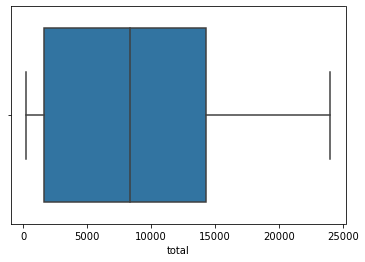

In [152]:
#%% data exploration
plt.figure()
#sns.boxplot(data=fullDataset[['Max Temp (C)', 'Min Temp (C)', 'Mean Temp (C)', 'Total Rain (mm)',
#                             'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)']])

plt.figure()
sns.boxplot(fullDataset['total'])

we can see that it does, with all the temp fields being in the expected range for Ottawa. and all the preciptation fields making sense. 

we can see that there are some outliers in the preciptation fields. or...outliers as the boxplot shows. but are these really outliers? a day with particularly heavy rain/snowfall is not really an outlier, as we expect that to have a real impact on the predicted cyclist count for that day. plus, we want our model to be able to predict cyclist counts on days with abnormally high precipitation. 

now let's see if there are any linear correlations. a good place to start might be the max temperature. we'd expect to see more cyclists out in the city on warmer days (ie spring and summer, not fall and winter). so let's see if that relationship is there.

Text(0, 0.5, 'number of cyclists, all sensors')

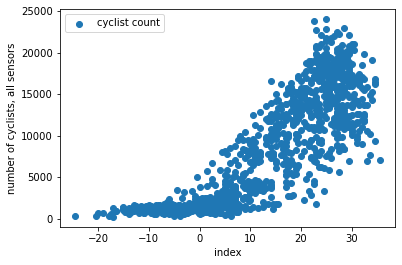

In [153]:
plt.figure()
plt.scatter(fullDataset['Max Temp (C)'],fullDataset['total'], label = 'cyclist count')
plt.legend()
plt.xlabel('index')
plt.ylabel('number of cyclists, all sensors')

so the relationship is there, but it doesn't look linear. if anything it looks exponential. most machine learning regression estimators can handle this, but they tend to like linear relationships better. so let's see if this one can be linearized. we'll attempt this by making the same plot, but using the log of the cyclist count (using np.log())

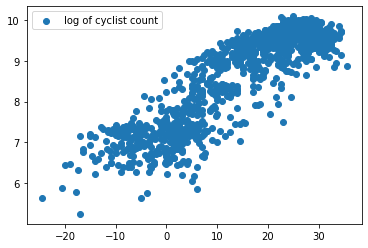

In [154]:
plt.figure()
plt.scatter(fullDataset['Max Temp (C)'],np.log(fullDataset['total']), label = 'log of cyclist count')
plt.legend()

that looks much more linear. so we'll need to remember to take this into account later when we start fitting estimators.

now that we have verified this relationship, let's check out the heatmap of correlation coefficients of all the variables in teh set to see if there are other interesting ones.

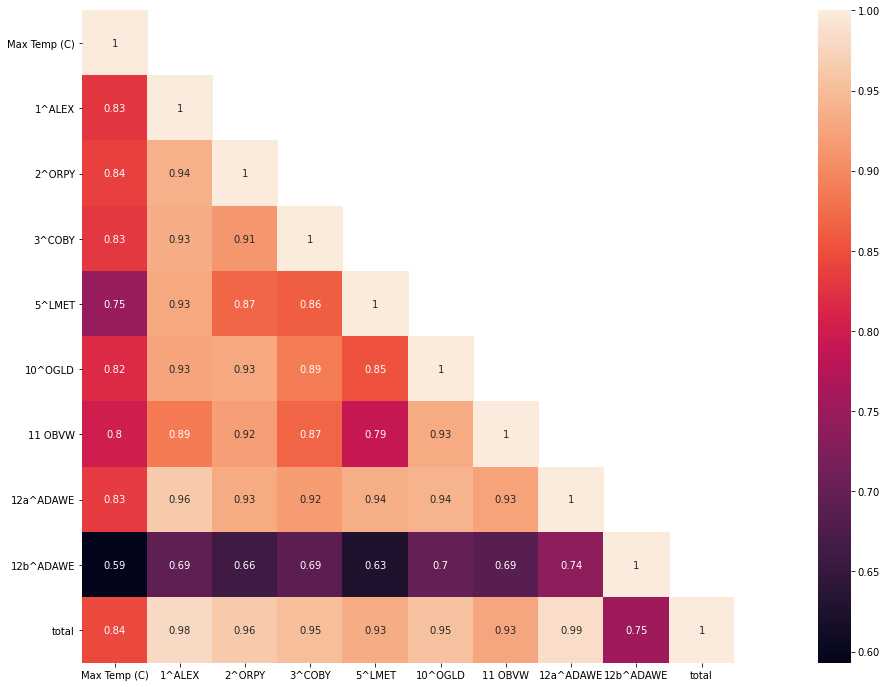

In [155]:

cor_mat= fullDataset[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)


some intersting takeaways from this heatmap:
1. max temp is correlated more strongly with all sensors (and total) than min temp and mean temp. i had expected all 3 of these to be multicolinear with each other, but it seems max temp has the strongest correlation with the output. this may be helpful later
2. snow on the ground is strongly negatively correlated with the total. makes sense. who wants to ride bikes when there's snow on the ground.
3. no correlation coefficient available between the categorical variables (weekday, holiday, tour de france day)


anyway, now it's time to build some models. first, some pre-preprocessing and organization. our target variable (the thing we are trying to predict) is the total number of cyclists. so let's define that and create our proper X and Y matrices, using only the weather data and the total cyclists. the X will be formed from the fullDataset dataframe with the sensor and date columns dropped. the Y matrix is just the 'total' column of the fullDataset dataframe

In [156]:
#%% target variable
target = 'total'

#%% split into X and Y
if 'Date' in sensorList:
    sensorList.remove('Date')
X = fullDataset.drop(columns = sensorList)

target = 'total'
Y = fullDataset[target]
X = X.drop(columns = target)
display('X matrix')
display(X.head())
display('Y matrix')
display(Y.head())

'X matrix'

,Max Temp (C),weekday,holiday?,world tour?,precip level,snow cover
0,-0.1,Friday,holiday,no tour,no precip,high snowcover
1,-0.1,Saturday,non-holiday,no tour,no precip,high snowcover
2,-0.2,Sunday,non-holiday,no tour,no precip,high snowcover
3,-14.7,Monday,non-holiday,no tour,no precip,high snowcover
4,-7.4,Tuesday,non-holiday,no tour,no precip,high snowcover


'Y matrix'

0    787.0
1    642.0
2    662.0
3    786.0
4    953.0
Name: total, dtype: float64

next, we'll split the data into training set and test set. and i will also jump high up on my soapbox and gripe about a very confusing phenomenon that occurs in the pandas/python relationship that caused me to pull lots of hair out when first programming this.

if i were to use train/test split the normal way, ie this way:
X_train, X_test, Y_train, Y_test, = train_test_split(X,Y,test_size = 0.2)

all 4 dataframes on the left would be assigned with their indexes scrambled. you can see this by doing it and displaying the dataframe. this is fine and what we expect from this operation.


In [157]:
X_train, X_test, Y_train, Y_test, = train_test_split(X,Y,test_size = 0.2)
display(Y_train)

177    19287.0
21      1355.0
149    11694.0
186    18455.0
226     9153.0
        ...   
183    16811.0
160    14048.0
120    15167.0
300     1354.0
304     7759.0
Name: total, Length: 862, dtype: float64

however, if you wanted to plot any column of this dataframe (plot, not scatter), python/pandas/matplotlib would assume you want them plotted back in index order. we can see this because of the seasonality and shape of the data. even though we have dropped the date from the dataframe, this is clearly being printed in date order. with jan-march at the beginning with very few cyclists, increasing rapidly to high numbere in the spring and summer (indexes 125-250), and then declining sharply in the fall and winter(indexes 300-325).

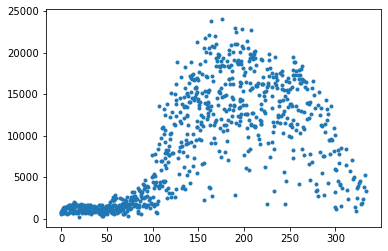

In [158]:
plt.plot(Y_train, linestyle = 'none', marker = '.')

ordinarily this would not be a problem. but recall that we are now being shown a graph that is in index order, but it is of data that, when we look at it in tabular form, is shown shuffled.

now suppose we now carry on with building our model, use it to predict cyclist counts, and then want to plot them on the above graph. they would plot out of order and not show the shape/seasonality of this data (trust me on this). that's because the predicted values would be assigned new indices. this makes sense as will be a brand new variable, which was created from a varaible whose indexes were shuffled by train/test split. as such, if you were to plot those values on the above graph using plot(), they would show all over the place. they would be in their own index order, but that order would not match the unshuffled index order of the training data.

while first building this model this took me forever to figure out. i kept thinking there was something wrong with my model that it was making terrible predictions. when in reality the predictions were quite good, but the shape of the data looked awful because the 1st series, which is the training data, was plotted in index order (python/pandas/mpl assumed i wanted it that way) and the 2nd series, the predicted data, was plotted out of index order.

now technically i realize this doesn't break any rules and i guess it is consistent. i just wish there was some way for matplotlib to tell the programmer when using plot() that it is assuming you want it plotted in index order, when the way the variable is displayed in tabular form, would be in shuffled order. maybe this reveals a gap in my knowledge of the interactions between these 3 entities, or in python as a whole, but if mpl plotted the first graph in the shuffled order in which it is displayed, i would have seen my error much more quickly. thanks for listening, rant over.

# Train/Test Split and Preprocessing

now there is a simple solution to the above problem that i have not seen taught in any machine learning courses i have taken. the first step is to create a variable of just integers that represent the original unshuffled indices of the X-matrix. then, take that variable and pass it through the train/test split alongside the X and Y matrices. this variable will be split into 2 (a train and a test) and each will hold the indices of the train/test matrices of the X and Y matrices. this way, if you ever want to plot and overlay, there is a varaible with the shuffled indices you can plot against. we'll do that in the step below and later see how it turns out.

In [159]:
#%% train test split while preserving index
idx=range(len(X))
X_train, X_test, Y_train, Y_test, idx_train, idx_test = train_test_split(X,Y,idx, 
                  test_size = 0.2, 
                  random_state = 42, 
                  shuffle = True)

we have some continuous and some categorical data here, so we will need to transform (scale/encode) each group of columns separately. i do this by splitting the training and test sets into subsets each with consistent datatype so i can look into them later if i need to. dtypes() and select_dtypes() are VERY helpful here. 


In [160]:
#%% preprocessing, training set
scaler = StandardScaler()
mms = MinMaxScaler(feature_range = (0,1))
ohe = OneHotEncoder(drop = 'if_binary', sparse = False)

Xtr_cont = X_train.select_dtypes(include = 'float64')

Xtr_categ = X_train.select_dtypes(exclude = 'float64')
Xtr_categ = Xtr_categ.astype('category')

Xtr_scaled = mms.fit_transform(Xtr_cont)

Xtr_enc = ohe.fit_transform(Xtr_categ)
Xtr_prepd = np.concatenate([Xtr_scaled, Xtr_enc], axis=1)

Xtr_prepd = pd.DataFrame(Xtr_prepd)

a few specific things to note about the above and below operations:
1. i've read that while the standard scaler would normally be the correct way to center/scale the data, when using continuously scaled data alongside one hot encoded data, putting centering/scaling the continous data along the range [0,1] will give better results, which is easier with the min/max scaler, as we can pass it an exact range to use
2. passing "drop='if binary'" is a cool trick i learned to prevent the dummy variable trap when using a OHE on data that is both binary (like our holiday column essentially being boolean) and categorical (day name). the encoder will drop the 2nd (unneccessary/dangerous) encoded column when the data has only 2 categories (like holiday/non-holiday). but will not drop any columns when encoding columns with higher cardinality
3. casting non-continous columns as 'category' i have read to be more efficient during the fitting process

4. notice below, on the test set, for the continuous data, we are using a new scaler object. this is because while we are pretty sure the training set and the test set come from the distribution of continuous values (in fact, we know this), we have to pretend we've never seen the test set before. so we will give use a new object. similarly, for the categorical data, we are using a new encoder object. but we are passing it the columns that the training set encoder came up with. this allows us to "pretend we've never seen the test set before" while at the same time knowing that the data will fall into categories that we have already defined (ie the ones taken from the training set)

In [161]:
display(X_test)

,Max Temp (C),weekday,holiday?,world tour?,precip level,snow cover
149,22.5,Tuesday,non-holiday,no tour,low precip,no snowcover
274,20.5,Monday,non-holiday,no tour,no precip,no snowcover
236,27.5,Saturday,non-holiday,no tour,no precip,no snowcover
313,-4.5,Friday,non-holiday,no tour,no precip,no snowcover
265,16.5,Sunday,non-holiday,no tour,no precip,no snowcover
...,...,...,...,...,...,...
183,30.5,Wednesday,non-holiday,no tour,no precip,no snowcover
10,-15.0,Friday,non-holiday,no tour,no precip,med snowcover
78,0.0,Tuesday,non-holiday,no tour,no precip,high snowcover
135,21.0,Tuesday,non-holiday,no tour,no precip,no snowcover


In [162]:
#%% preprocessing, test set
mms_test = MinMaxScaler(feature_range = (0,1))
ohe_test = OneHotEncoder(categories = ohe.categories_, drop = 'if_binary', sparse = False)

Xte_cont = X_test.select_dtypes(include = 'float64')
Xte_categ = X_test.select_dtypes(exclude = 'float64')
Xte_categ = Xte_categ.astype('category')

Xte_scaled = mms_test.fit_transform(Xte_cont)
Xte_scaled = mms.transform(Xte_cont)
Xte_scaled.shape

Xte_enc = ohe_test.fit_transform(Xte_categ)
Xte_enc = ohe.transform(Xte_categ)
Xte_enc.shape
Xte_prepd = np.concatenate([Xte_scaled, Xte_enc], axis=1)
        

Xte_prepd = pd.DataFrame(Xte_prepd)
Xte_prepd.shape

(216, 18)

# Model Building

now we can build some models. we'll start with a group of the most basic regressor estimators, and throw in an ensemble one just for fun. we'll put these models in a list and loop through them. 

now, remember how we learned that one of the main correlations we expected turned out to be an exponential relationship, as opposed to a linear one, and how we took the np.log() of the cyclist count to see the linear relationship? well technically we could create a new target variable column which was the log of the original column, build our models, make predictions, and then back-caculate the actual counts and errors. but sklearn knows we're lazier than that. so they've built an object that does all that for us. ie will apply a transormation to the target data at the same time as fitting models and using them to predict data. we just need to specify the function used to transform the data, as well as the inverse function to un-transform it. this keeps things a lot cleaner. it's called TransformedTargetRegressor() and it's very handy.

anyway, for each estimator, we will first build it into a TTE using np.log(), then fit it to the training data, then use it to predict some counts using the test data, then calculate the RMSE as a way of ranking the estimator performance. for now, we will take all the default hyperparameters. when we land on a estmator, we will then go and tune it.

In [163]:
#%%build models

svr = svm.SVR(kernel = 'rbf')
linear = linear_model.LinearRegression(fit_intercept = False)
lasso = linear_model.Lasso()
rfr = RandomForestRegressor()

estimatorQueue = [svr, linear, lasso, rfr]

rmsle = []
rmse = []

for i in range(len(estimatorQueue)):
    regr_trans = TransformedTargetRegressor(regressor=estimatorQueue[i],
                                        func=np.log1p,
                                        inverse_func=np.expm1)
    regr_trans.fit(Xtr_prepd,Y_train)
    
    Y_pred_t = regr_trans.predict(Xte_prepd)        

    model_rmse_trans = mean_squared_error(Y_test,Y_pred_t, squared = False)
    
    rmse.append(model_rmse_trans)
    
    
results = {'Estimator':estimatorQueue, 'RMSE': rmse} 
results = pd.DataFrame(results)
display(results)

,Estimator,RMSE
0,SVR(),2521.342603
1,LinearRegression(fit_intercept=False),2760.870163
2,Lasso(),7590.591484
3,RandomForestRegressor(),2408.625669


as expected, the RandomForestRegressor() performed the best. this shouldn't be a surprise because of the way it's structured. 

the RFR starts by taking a group of random data points and fitting a decision tree to them to make a prediction. then the RFR picks a new group of points, and fits a new decision tree. then, after this is done hundreds (or thousands?) of times, the estimator takes an average of the predictions of all the trees. it's a very powerful algorithm. read more here: https://medium.com/swlh/random-forest-and-its-implementation-71824ced454f

now let's take a look at how the predictions on the test data fit with the test data. recall the trick we used earlier of passing an index vector to the train/test split so we could keep track of the shuffle. this will allow us to plot the test data and the predictions on the same axes and they will both be in index order. ie the order of the original X-matrix before it got shuffled in the train/test split.

Text(0, 0.5, 'cyclists on road')

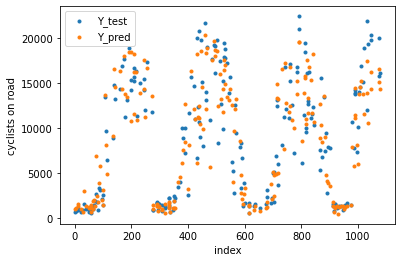

In [164]:
#%% data exploration
plt.figure()
plt.scatter(idx_test,Y_test, label = 'Y_test', linestyle = 'None', marker = '.')
plt.scatter(idx_test,Y_pred_t, label = 'Y_pred', linestyle = 'None', marker = '.')
plt.legend()
plt.xlabel('index')
plt.ylabel('cyclists on road')

ok now this looks pretty good. we can see that our predictions more or less follow the seasonality of the test data. and we know from the results table a few cells ago that on average this set of predictions is about 2500 riders off from the true number. which, during the winters where there's only 1000-2000 riders out, is not very good. but in the summer when counts are reaching almost 25,000 riders, that's pretty good.

by the way, if a more learned machine learning engineer out there has a recommendation of a better scoring function to use in cases like this, i would love to hear it. by that i mean that saying the RMSE is about 2000 riders doesn't quite account for the fact that when there's 1000-2000 riders out, the model does pretty good. and when there are 15000-25000 riders out, a RMSE of 2500 riders is decent. there has got to be a better method of scoring the predictions that accounts for this phenomenon.

# Model Tuning

regardless, for now let's continue with the random forest regressor and tune it for even better results using GridSearchCV. unfortunately, we can't use the TTR within the GridSearchCV() so we have to construct it with a generic RFR and fit it to the log of Y_train.

in order to make the below code cells work, you will need to uncomment line 13 below. currently it is commented out to prevent the gridsearch from occuring. this is a computationally-intensive and long-duration command that i would like to skip as i built the notebook.

In [165]:
#%%instantiate winning model for tuning and feature work
rfr_trans = TransformedTargetRegressor(regressor=rfr,
                                        func=np.log1p,
                                        inverse_func=np.expm1)

rfr_trans.fit(Xtr_prepd, Y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=RandomForestRegressor())

In [166]:
#%% model tuning
param_dict = { 
    "n_estimators"      : [100, 200, 500],
    "max_features"      : ["auto", "sqrt", "log2"],
    "min_samples_split" : [8, 16, 32],
    "bootstrap": [True, False],
    }

rfr_grid=GridSearchCV(estimator=RandomForestRegressor(),
                    param_grid=param_dict,
                    verbose = 5)

#rfr_grid.fit(Xtr_prepd,np.log(Y_train))
rfr_grid.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, score=0.898, total=   0.8s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, score=0.909, total=   0.8s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, score=0.914, total=   0.9s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s


[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, score=0.885, total=   0.8s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.3s remaining:    0.0s


[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=100, score=0.886, total=   0.8s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=200, score=0.900, total=   1.6s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=200, score=0.908, total=   1.5s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=200, score=0.913, total=   1.4s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=200, score=0.886, total=   1.5s
[CV] bootstrap=True, max_features=auto, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_features=auto, min_samples_split=8, n_estima

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.4min finished


{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_split': 8,
 'n_estimators': 500}

now let's build a RFR, wrapped in a TTR, with the best parameters as discovered by the GridSearchCV. then we can fit it and run the permutation importance function on it, which will give us direction for feature engineering

In [167]:
#%% prep for feature importances

#re-fit model with best params
rfr_best=RandomForestRegressor(n_estimators = 500,
                               min_samples_split= 8,
                               max_features = 'auto',
                               bootstrap = True)

best_model = TransformedTargetRegressor(regressor=rfr_best,
                                        func=np.log1p,
                                        inverse_func=np.expm1)
best_model.fit(Xtr_prepd,Y_train)

Y_pred_best = best_model.predict(Xte_prepd)
best_rmse = mean_squared_error(Y_test, Y_pred_best, squared = False)
print(best_rmse)
print('tuning improvement percentage: ')
print(results['RMSE'].iloc[-1] / best_rmse)


2328.4983054712234
tuning improvement percentage: 
1.0344116047856549


tuning got us a 3.4% improvement in model predictive accuracy (as defined by RMSE). small improvement, but not nothing. perhaps some feature engineering will help us do better. best RMSE so far: ~2046

# Feature Importances and Engineering

In [168]:
#%% feature importances
fe_im = permutation_importance(best_model, Xtr_prepd, Y_train)
importances = pd.DataFrame(fe_im.importances_mean)

allCategories = list(Xtr_cont.columns)
allCategories.extend(ohe.get_feature_names())

importances['feature']=allCategories

In [169]:
display(importances.sort_values(by = 0, ascending = False))

,0,feature
0,1.267929,Max Temp (C)
3,0.081660,x0_Saturday
4,0.057800,x0_Sunday
17,0.057692,x4_no snowcover
13,0.032993,x3_no precip
10,0.017417,x3_high precip
14,0.012832,x4_high snowcover
9,0.012481,x2_tour
1,0.010705,x0_Friday
8,0.010058,x1_non-holiday


a few fun takaways from this exercise:

1. max temp matters way more than mean or min temp. makes sense i guess but i didn't think the difference would be that drastic. to simplify the model, we can remove mean and min temp columns. which are probably causing multicolinearity problems anyway.

2. snow on ground matters more than precip of any kind. this probably means that for some riders, as long as there's no snow on the ground some riders will be out there, regardless of the precipitation. whether these be commuters or pleasure riders, these are what we in the community would call "the Hardmen". we can simplify the model by removing Total snow, which barely matters at all. if we wanted, we could go further and remove total rain in favor of simply "total precip". or we could bin the precip amounts by mm/cm, or simply "hi/med/low".

3. weekend being true probably matters more than specifically what day of week it is. if we wanted we could simplify the model by having this be a binary/boolean variable of just "weekday?" (Y/N)

4. holiday or non-holiday matters the same amount as whether the tour de france is currently running. no real insight to gain here other than admitting that hey...there's probably a few people out there on bikes simply because the entire (pro) cycling world is paying attention to this event. or, in the cycling world, the tour de france is the equivalent of a holiday

just for fun, let's remove the variables that are not helping the model, and bin the total precip and snowcover variables. to do this we can make use of pandas cut() function which i just discovered. it takes a numeric pandas series and replaces the numbers with labels according to a ranged map passed to it. super simple and convenient.

In [170]:
#%% feature engineering

def featureEngineering(weatherData):

    weatherData_raw = weatherData
    weatherData = weatherData.drop(columns = 'Total Snow (cm)')
    
    precipBins = [-1,3, 6, 9, weatherData['Total Precip (mm)'].max()+1]
    labels = ['no precip', 'low precip','med precip','high precip']
    weatherData['precip level'] = pd.cut(weatherData['Total Precip (mm)'], 
                                         bins=precipBins, labels=labels)
    weatherData = weatherData.drop(columns = 'Total Precip (mm)')
    
    groundSnowBins = [-1,3, 6, 9,weatherData['Snow on Grnd (cm)'].max()+1]
    labels = ['no snowcover', 'little snowcover', 'med snowcover','high snowcover']
    weatherData['snow cover'] = pd.cut(weatherData['Snow on Grnd (cm)'], 
                                        bins=groundSnowBins, labels=labels)
    weatherData = weatherData.drop(columns = 'Snow on Grnd (cm)')
    
    dropList = ['Min Temp (C)', 'Mean Temp (C)', 'Total Rain (mm)']
    weatherData = weatherData.drop(columns = dropList)

    return weatherData


In [171]:
weatherData_eng = featureEngineering(weatherData)
display(weatherData_eng)


,Date/Time,Max Temp (C),weekday,holiday?,world tour?,precip level,snow cover
0,2016-01-01,-0.1,Friday,holiday,no tour,no precip,high snowcover
1,2016-01-02,-0.1,Saturday,non-holiday,no tour,no precip,high snowcover
2,2016-01-03,-0.2,Sunday,non-holiday,no tour,no precip,high snowcover
3,2016-01-04,-14.7,Monday,non-holiday,no tour,no precip,high snowcover
4,2016-01-05,-7.4,Tuesday,non-holiday,no tour,no precip,high snowcover
...,...,...,...,...,...,...,...
360,2019-12-27,3.5,Friday,non-holiday,no tour,no precip,no snowcover
361,2019-12-28,3.5,Saturday,non-holiday,no tour,no precip,no snowcover
362,2019-12-29,0.5,Sunday,non-holiday,no tour,no precip,no snowcover
363,2019-12-30,-1.0,Monday,non-holiday,no tour,high precip,no snowcover


In [172]:
display(weatherData_eng['precip level'].value_counts())
display(weatherData_eng['snow cover'].value_counts())

no precip      1130
high precip     140
low precip      103
med precip       68
Name: precip level, dtype: int64

no snowcover        992
high snowcover      328
little snowcover     73
med snowcover        50
Name: snow cover, dtype: int64

now that we have done some of the feature engineering suggested by the feature importances, we can go back and fit/predict again to try and beat ~2046. to accomplish this easily, simply uncomment line 3 in the "compile full dataset" code cell and re-run the notebook.

In [173]:
print(best_rmse)


2328.4983054712234


ah. unfortunately, making those feature engineering changes hurt the predictive ability of the model - they didn't help it. sometimes this can happen in the world of machine learning. and that's the beauty of it. at some point, we can't know exactly how the processor is using the data to make its guesses. i mean technically we can look under the hood for each function, but at this point we should be satisfied knowing that leaving the variables the way they are is going to give us the best predictions.

# Conclusions/suggestions for future work

thanks to the reader for following along this notebook! here are some intresting conclusions and things i've learned from building it.
1. love it or hate it, pandas/python/sklearn probably has a function for doing EXACTLY what you want to do. i found this out while working on this project, especially pd.DataFrame.select_dtypes, and pd.cut().
2. i will never make the mistake of forgetting that plt.plot() assumes the user wants index order EVER AGAIN. i can see lots of beginners falling into this trap, and would even say my realizing this was a big moment in my growth from beginniner python land
3. i'm surprised to learn that when it comes to what causes people to get out on their bikes, outdoor temperature is still king. and that it's the daily high that matters more than any other piece of weather data. i guess this makes sense because people will ride on a winter's day that just happens to be randomly warm (as long as there's no snow on the ground).

some ideas i have of how to improve this project would be:
1. to get more samples, we could go back further (we did 4 years...but could easily go back as far as data allows). or we could take each day that has a sensor that is not reporting data and try and predict that sensor's reading using a model like this one (maybe using other sensors' data as counts?). this would prevent us from losing so many days' worth of dta and render a more accurate model.

2. we could leave the weather data as continuous, but instead of leaving day name and holiday/non-holiday, we could combine these into a boolean feature of "work day/non work day". this would be a good way of capturing the number of riders out who are commuters

3. it would be cool to repeat this exercise but look at each sensor individually. then, for a given date in the future, you would predict how many riders would pass by each sensor. this would be a good input into another machine learning algorithm that might predict cyclist collisions. or could clue a savvy business owner into knowing where to set up a pop up bike shop. or an espresso cart. bikers love espresso.